In [1]:
## The imports 
import numpy as np
from PIL import Image 
import cv2
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

In [2]:
#define Variables
HIGHWAY1_PATH = 'Images/highway1.jpg'
HIGHWAY2_PATH = 'Images/highway2.jpg'

In [4]:
# We need to read the images that are located in our files
Highway1_img = cv2.imread(HIGHWAY1_PATH, 0) 
Highway2_img = cv2.imread(HIGHWAY2_PATH, 0) 
                          
## we willl apply the edge detection to thr next part            
edge_image1 = cv2.GaussianBlur(Highway1_img, (3, 3), 1)
edge_image1 = cv2.Canny(edge_image1, 100, 200)

edge_image2 = cv2.GaussianBlur(Highway2_img, (3, 3), 1)
edge_image2 = cv2.Canny(edge_image2, 100, 200)


In [15]:
#functions
def Lines_Detection_Hough(image, edge_image, number_theta, number_rho):
    Dtheta = 180 / number_theta
    edge_height, edge_width = edge_image.shape[0], edge_image.shape[1]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    
    max_p = np.sqrt(np.square(edge_height) + np.square(edge_width))
    Drho = (2 * max_p) / number_rho
    
    thetas = np.arange(0, 180, step=Dtheta)
    rhos = np.arange(-max_p, max_p, step=Drho)

    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    #
    accumulator = np.zeros((len(rhos), len(rhos)))
    #
    figure = plt.figure(figsize=(12, 12))
    subplot1 = figure.add_subplot(1, 4, 1)
    subplot1.imshow(image)
    subplot2 = figure.add_subplot(1, 4, 2)
    subplot2.imshow(edge_image, cmap="gray")
    subplot3 = figure.add_subplot(1, 4, 3)
    subplot3.set_facecolor((0, 0, 0))
    subplot4 = figure.add_subplot(1, 4, 4)
    subplot4.imshow(image)
    #
    for y in range(edge_height):
        for x in range(edge_width):
            if edge_image[y][x] != 0:
                edge_point = [y - edge_height_half, x - edge_width_half]
                #edge_point = [y, x]
                ys, xs = [], []
                for theta_idx in range(len(thetas)):
                    rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                    theta = thetas[theta_idx]
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx][theta_idx] += 1
                    ys.append(rho)
                    xs.append(theta)
                subplot3.plot(xs, ys, color="white", alpha=0.05)
                
                
    for y in range(accumulator.shape[0]):
        for x in range(accumulator.shape[1]):
            if accumulator[y][x] > number_rho:
                rho = rhos[y]
                theta = thetas[x]
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho) + edge_width_half
                y0 = (b * rho) + edge_height_half
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                subplot3.plot([theta], [rho], marker='o', color="yellow")
                subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

        subplot3.invert_yaxis()
        subplot3.invert_xaxis()

        subplot1.title.set_text("Original Image")
        subplot2.title.set_text("Edge Image")
        subplot3.title.set_text("Hough Space")
        subplot4.title.set_text("Detected Lines")
        plt.show()
    return accumulator, rhos, thetas



def line_detection_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=700):
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    #
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    #
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    #
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    #
    accumulator = np.zeros((len(rhos), len(rhos)))
    #
    figure = plt.figure(figsize=(12, 12))
    subplot1 = figure.add_subplot(1, 4, 1)
    subplot1.imshow(image)
    subplot2 = figure.add_subplot(1, 4, 2)
    subplot2.imshow(edge_image, cmap="gray")
    subplot3 = figure.add_subplot(1, 4, 3)
    subplot3.set_facecolor((0, 0, 0))
    subplot4 = figure.add_subplot(1, 4, 4)
    subplot4.imshow(image)
    #
    edge_points = np.argwhere(edge_image != 0)
    edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
    #
    rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
    #
    accumulator, theta_vals, rho_vals = np.histogram2d(
      np.tile(thetas, rho_values.shape[0]),
      rho_values.ravel(),
      bins=[thetas, rhos]
   )
    accumulator = np.transpose(accumulator)
    lines = np.argwhere(accumulator > t_count)
    rho_idxs, theta_idxs = lines[:, 0], lines[:, 1]
    r, t = rhos[rho_idxs], thetas[theta_idxs]

    for ys in rho_values:
        subplot3.plot(thetas, ys, color="white", alpha=0.05)

    subplot3.plot([t], [r], color="yellow", marker='o')

    for line in lines:
        y, x = line
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

    subplot3.invert_yaxis()
    subplot3.invert_xaxis()

    subplot1.title.set_text("Original Image")
    subplot2.title.set_text("Edge Image")
    subplot3.title.set_text("Hough Space")
    subplot4.title.set_text("Detected Lines")
    plt.show()
    return accumulator, rhos, thetas

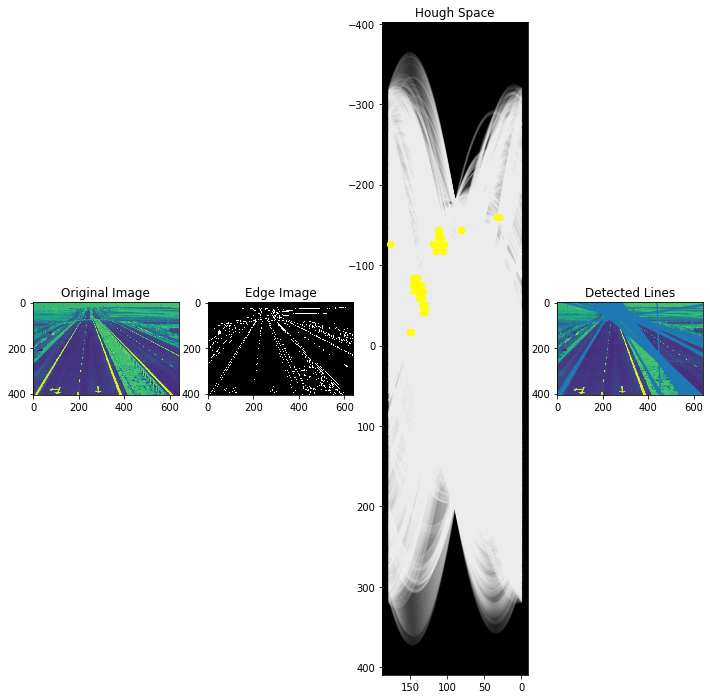

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-7.57915563e+02, -7.49494279e+02, -7.41072995e+02, -7.32651710e+02,
        -7.24230426e+02, -7.15809142e+02, -7.07387858e+02, -6.98966574e+02,
        -6.90545290e+02, -6.82124006e+02, -6.73702722e+02, -6.65281438e+02,
        -6.56860154e+02, -6.48438870e+02, -6.40017586e+02, -6.31596302e+02,
        -6.23175018e+02, -6.14753734e+02, -6.06332450e+02, -5.97911166e+02,
        -5.89489882e+02, -5.81068598e+02, -5.72647314e+02, -5.64226030e+02,
        -5.55804746e+02, -5.47383462e+02, -5.38962178e+02, -5.30540894e+02,
        -5.22119610e+02, -5.13698326e+02, -5.05277042e+02, -4.96855758e+02,
        -4.88434474e+02, -4.80013190e+02, -4.71591906e+02, -4.63170622e+02,
        -4.54749338e+02, -4.46328054e+02, -4.37906769e+02, -4.29485

In [16]:
line_detection_vectorized(Highway2_img, edge_image2)

In [34]:
line_detection_non_vectorized(Highway2_img, edge_image2)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000025E7824DCA8> (for post_execute):


KeyboardInterrupt: 

In [6]:
    
image = Highway2_img
edge_image = edge_image2
number_theta = 180
number_rho = 180
t_count = 220
Dtheta = 180 / number_theta
edge_height, edge_width = edge_image.shape[0], edge_image.shape[1]
edge_height_half, edge_width_half = edge_height / 2, edge_width / 2

max_p = np.sqrt(np.square(edge_height) + np.square(edge_width))
Drho = (2 * max_p) / number_rho

thetas = np.arange(0, 180, step=Dtheta)
rhos = np.arange(-max_p, max_p, step=Drho)

cos_thetas = np.cos(np.deg2rad(thetas))
sin_thetas = np.sin(np.deg2rad(thetas))
#
accumulator = np.zeros((len(rhos), len(rhos)))

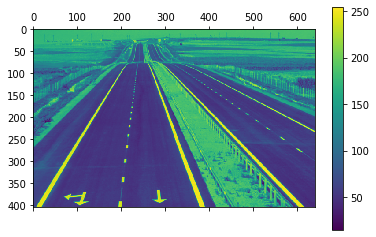

In [9]:
plt.matshow(image);
plt.colorbar()
plt.show()

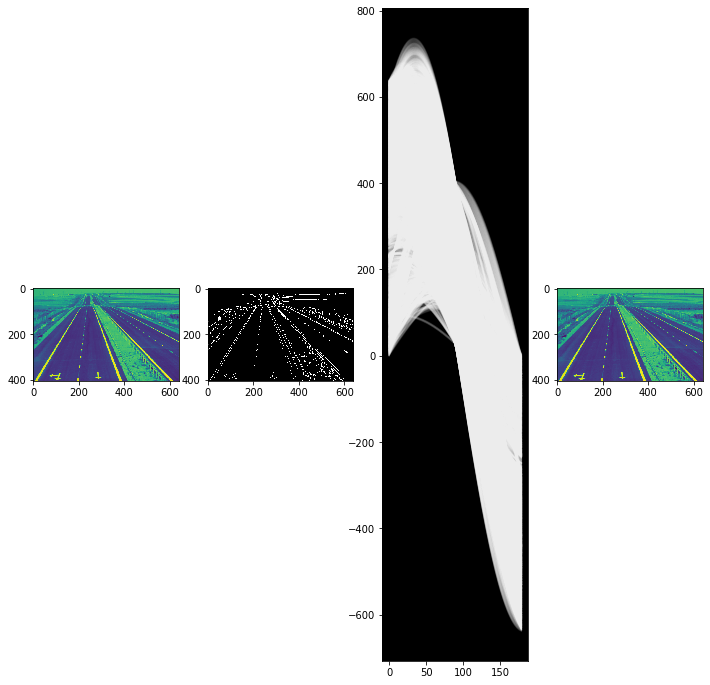

In [10]:
#
figure = plt.figure(figsize=(12, 12))
subplot1 = figure.add_subplot(1, 4, 1)
subplot1.imshow(image)
subplot2 = figure.add_subplot(1, 4, 2)
subplot2.imshow(edge_image, cmap="gray")
subplot3 = figure.add_subplot(1, 4, 3)
subplot3.set_facecolor((0, 0, 0))
subplot4 = figure.add_subplot(1, 4, 4)
subplot4.imshow(image)
#
for y in range(edge_height):
    for x in range(edge_width):
        if edge_image[y][x] != 0:
            #edge_point = [y - edge_height_half, x - edge_width_half]
            edge_point = [y, x]
            #edge_point = [y, x]
            ys, xs = [], []
            for theta_idx in range(len(thetas)):
                rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                theta = thetas[theta_idx]
                rho_idx = np.argmin(np.abs(rhos - rho))
                accumulator[rho_idx][theta_idx] += 1
                ys.append(rho)
                xs.append(theta)
            subplot3.plot(xs, ys, color="white", alpha=0.05)

In [32]:
figure = plt.figure(figsize=(12, 12))
subplot1 = figure.add_subplot(1, 4, 1)
subplot1.imshow(image)
subplot2 = figure.add_subplot(1, 4, 2)
subplot2.imshow(edge_image, cmap="gray")
subplot3 = figure.add_subplot(1, 4, 3)
subplot3.set_facecolor((0, 0, 0))
subplot4 = figure.add_subplot(1, 4, 4)
subplot4.imshow(image)
flag = 0
for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
#         print(accumulator[y][x])
        if accumulator[y][x] > 50:
            flag += 1
            rho = rhos[y]
            theta = thetas[x]
            a = np.cos(np.deg2rad(theta))
            b = np.sin(np.deg2rad(theta))
            if b == 0:
                continue
            x0 = int(rho / a)
            y0 = 0
            x1 = 0
            
            y1 = int(rho / b)
#             x2 = int(x0 - 1000 * (-b))
#             y2 = int(y0 - 1000 * (a))
            print(x0, y0)
            print(x1, y1)
            subplot3.plot([theta], [rho], marker='o', color="yellow")
            subplot4.add_line(mlines.Line2D([x0, x1], [y0, y1]))
#     if flag > 20:
#         break
# subplot3.invert_yaxis()
# subplot3.invert_xaxis()

subplot1.title.set_text("Original Image")
subplot2.title.set_text("Edge Image")
subplot3.title.set_text("Hough Space")
subplot4.title.set_text("Detected Lines")
plt.show()
print(flag)

-467 0
0 17254
-463 0
0 17301
-460 0
0 16807
-458 0
0 16734
-458 0
0 17114
-456 0
0 16848
-447 0
0 16333
-445 0
0 16260
-444 0
0 16405
-443 0
0 16939
-441 0
0 16295
-440 0
0 16077
-440 0
0 16258
-440 0
0 16442
-438 0
0 16556
-437 0
0 16147
-437 0
0 16330
-437 0
0 16907
-435 0
0 15895
-435 0
0 17030
-434 0
0 16405
-433 0
0 15822
-431 0
0 15926
-431 0
0 17498
-430 0
0 16443
-429 0
0 15676
-429 0
0 15852
-428 0
0 15815
-427 0
0 15957
-426 0
0 15566
-426 0
0 15920
-425 0
0 15530
-424 0
0 15493
-424 0
0 15667
-423 0
0 15630
-423 0
0 16366
-423 0
0 16560
-422 0
0 15420
-422 0
0 15771
-422 0
0 15952
-421 0
0 15556
-421 0
0 15733
-421 0
0 15914
-421 0
0 17525
-420 0
0 15520
-420 0
0 15696
-420 0
0 15876
-419 0
0 15311
-419 0
0 16404
-418 0
0 15274
-418 0
0 15446
-418 0
0 15984
-418 0
0 16172
-417 0
0 15409
-417 0
0 15763
-416 0
0 15372
-416 0
0 15547
-415 0
0 15165
-414 0
0 15128
-414 0
0 15298
-414 0
0 15472
-414 0
0 15650
-414 0
0 15832
-413 0
0 15092
-413 0
0 15435
-413 0
0 15979
-412 0
0 1

-223 0
0 8342
-223 0
0 8438
-223 0
0 8845
-223 0
0 9063
-222 0
0 8498
-222 0
0 8805
-222 0
0 9023
-221 0
0 8460
-221 0
0 8872
-220 0
0 8230
-220 0
0 8325
-220 0
0 8422
-220 0
0 8726
-220 0
0 8941
-219 0
0 8193
-219 0
0 8383
-219 0
0 8792
-219 0
0 8901
-218 0
0 8345
-218 0
0 9321
-217 0
0 7938
-217 0
0 8307
-217 0
0 8607
-217 0
0 8930
-216 0
0 7901
-216 0
0 8269
-216 0
0 8366
-215 0
0 7865
-215 0
0 8231
-215 0
0 8739
-214 0
0 7828
-214 0
0 8193
-214 0
0 8592
-214 0
0 8807
-213 0
0 7792
-213 0
0 8552
-213 0
0 8658
-212 0
0 8512
-211 0
0 7806
-211 0
0 8078
-211 0
0 8472
-211 0
0 8684
-210 0
0 7769
-210 0
0 7857
-210 0
0 7947
-210 0
0 8752
-209 0
0 7732
-209 0
0 7820
-209 0
0 8096
-209 0
0 8192
-209 0
0 8392
-209 0
0 8602
-208 0
0 7872
-208 0
0 8057
-208 0
0 8352
-208 0
0 8455
-208 0
0 8669
-207 0
0 8018
-207 0
0 8519
-207 0
0 8968
-206 0
0 7796
-206 0
0 7887
-206 0
0 7980
-206 0
0 8172
-206 0
0 8272
-205 0
0 7584
-205 0
0 7759
-205 0
0 8232
-205 0
0 8437
-204 0
0 7463
-204 0
0 7721
-204 0

-164 0
0 7719
-163 0
0 5967
-163 0
0 6034
-163 0
0 6103
-163 0
0 6173
-163 0
0 6245
-163 0
0 6318
-163 0
0 6393
-163 0
0 6470
-163 0
0 6549
-163 0
0 6630
-163 0
0 6713
-163 0
0 6798
-163 0
0 6974
-163 0
0 7066
-163 0
0 7160
-163 0
0 7257
-163 0
0 7356
-163 0
0 7459
-163 0
0 7564
-163 0
0 7672
-163 0
0 7783
-162 0
0 5931
-162 0
0 5997
-162 0
0 6065
-162 0
0 6279
-162 0
0 6354
-162 0
0 6431
-162 0
0 6509
-162 0
0 6589
-162 0
0 6672
-162 0
0 6756
-162 0
0 6843
-162 0
0 6932
-162 0
0 7023
-162 0
0 7116
-162 0
0 7311
-162 0
0 7413
-162 0
0 7517
-162 0
0 7625
-162 0
0 7735
-162 0
0 7849
-161 0
0 5894
-161 0
0 5960
-161 0
0 6028
-161 0
0 6097
-161 0
0 6168
-161 0
0 6241
-161 0
0 6315
-161 0
0 6391
-161 0
0 6469
-161 0
0 6549
-161 0
0 6631
-161 0
0 6715
-161 0
0 6801
-161 0
0 6889
-161 0
0 6980
-161 0
0 7073
-161 0
0 7367
-161 0
0 7578
-161 0
0 7688
-161 0
0 7801
-160 0
0 5858
-160 0
0 5923
-160 0
0 5991
-160 0
0 6059
-160 0
0 6130
-160 0
0 6276
-160 0
0 6351
-160 0
0 6429
-160 0
0 6508
-160 0

-122 0
0 5831
-122 0
0 6190
-122 0
0 8047
-122 0
0 8211
-121 0
0 4535
-121 0
0 4587
-121 0
0 5051
-121 0
0 5251
-121 0
0 5621
-121 0
0 5783
-121 0
0 5868
-121 0
0 7825
-121 0
0 8868
-120 0
0 4398
-120 0
0 4549
-120 0
0 4602
-120 0
0 4656
-120 0
0 4712
-120 0
0 5010
-120 0
0 5208
-120 0
0 5348
-120 0
0 5422
-120 0
0 5820
-120 0
0 7915
-119 0
0 4361
-119 0
0 4410
-119 0
0 4460
-119 0
0 4511
-119 0
0 4564
-119 0
0 4673
-119 0
0 4968
-119 0
0 5164
-119 0
0 5304
-119 0
0 5607
-119 0
0 8722
-118 0
0 4325
-118 0
0 4474
-118 0
0 4526
-118 0
0 4990
-118 0
0 5121
-118 0
0 5560
-118 0
0 5641
-118 0
0 5724
-118 0
0 8845
-117 0
0 4288
-117 0
0 4336
-117 0
0 4436
-117 0
0 4488
-117 0
0 4540
-117 0
0 4594
-117 0
0 4948
-117 0
0 5078
-117 0
0 5215
-117 0
0 7876
-116 0
0 4252
-116 0
0 4299
-116 0
0 4610
-116 0
0 4666
-116 0
0 4783
-116 0
0 4906
-116 0
0 5242
-116 0
0 5466
-116 0
0 8503
-115 0
0 4215
-115 0
0 4262
-115 0
0 4311
-115 0
0 4360
-115 0
0 4411
-115 0
0 4802
-115 0
0 4991
-115 0
0 5126
-115 0

-76 0
0 2991
-76 0
0 3027
-76 0
0 3064
-76 0
0 3180
-76 0
0 3221
-76 0
0 3263
-76 0
0 3306
-76 0
0 3350
-76 0
0 3442
-76 0
0 3490
-76 0
0 3589
-76 0
0 4487
-75 0
0 2755
-75 0
0 2786
-75 0
0 2818
-75 0
0 2850
-75 0
0 2883
-75 0
0 2917
-75 0
0 2952
-75 0
0 2987
-75 0
0 3024
-75 0
0 3100
-75 0
0 3139
-75 0
0 3179
-75 0
0 3220
-75 0
0 3263
-75 0
0 3306
-75 0
0 3351
-75 0
0 3397
-75 0
0 3444
-75 0
0 3646
-75 0
0 5510
-74 0
0 2719
-74 0
0 2749
-74 0
0 2780
-74 0
0 2812
-74 0
0 2948
-74 0
0 2984
-74 0
0 3058
-74 0
0 3097
-74 0
0 3137
-74 0
0 3178
-74 0
0 3219
-74 0
0 3262
-74 0
0 3306
-74 0
0 3352
-74 0
0 3398
-74 0
0 3598
-74 0
0 4369
-74 0
0 6991
-73 0
0 2682
-73 0
0 2712
-73 0
0 2743
-73 0
0 2807
-73 0
0 2840
-73 0
0 2908
-73 0
0 2944
-73 0
0 2980
-73 0
0 3095
-73 0
0 3135
-73 0
0 3176
-73 0
0 3219
-73 0
0 3262
-73 0
0 3307
-73 0
0 3353
-73 0
0 3400
-73 0
0 3603
-72 0
0 2675
-72 0
0 2706
-72 0
0 2801
-72 0
0 2869
-72 0
0 2904
-72 0
0 2940
-72 0
0 2976
-72 0
0 3092
-72 0
0 3133
-72 0
0 3175

0 1664
-37 0
0 1687
-37 0
0 1759
-37 0
0 1811
-37 0
0 1986
-37 0
0 3004
-37 0
0 3519
-37 0
0 8211
-36 0
0 1394
-36 0
0 1410
-36 0
0 1427
-36 0
0 1444
-36 0
0 1480
-36 0
0 1537
-36 0
0 1557
-36 0
0 1598
-36 0
0 1642
-36 0
0 1665
-36 0
0 1688
-36 0
0 1712
-36 0
0 1933
-36 0
0 2032
-36 0
0 2924
-36 0
0 7992
-35 0
0 1340
-35 0
0 1371
-35 0
0 1388
-35 0
0 1404
-35 0
0 1422
-35 0
0 1476
-35 0
0 1494
-35 0
0 1514
-35 0
0 1575
-35 0
0 1597
-35 0
0 1619
-35 0
0 1665
-35 0
0 1766
-35 0
0 1880
-35 0
0 2915
-34 0
0 1302
-34 0
0 1317
-34 0
0 1333
-34 0
0 1349
-34 0
0 1452
-34 0
0 1471
-34 0
0 1491
-34 0
0 1552
-34 0
0 1573
-34 0
0 1827
-34 0
0 1920
-33 0
0 1264
-33 0
0 1279
-33 0
0 1294
-33 0
0 1310
-33 0
0 1325
-33 0
0 1341
-33 0
0 1358
-33 0
0 1410
-33 0
0 1429
-33 0
0 1507
-33 0
0 1528
-33 0
0 1571
-33 0
0 1594
-33 0
0 1774
-33 0
0 1865
-33 0
0 3056
-32 0
0 1227
-32 0
0 1255
-32 0
0 1270
-32 0
0 1286
-32 0
0 1301
-32 0
0 1404
-32 0
0 1423
-32 0
0 1442
-32 0
0 1462
-32 0
0 1482
-32 0
0 1503
-32 0

17 0
0 -718
17 0
0 -727
17 0
0 -787
17 0
0 -798
17 0
0 -809
17 0
0 -821
17 0
0 -833
17 0
0 -857
17 0
0 -870
18 0
0 -741
18 0
0 -750
18 0
0 -769
18 0
0 -779
18 0
0 -832
18 0
0 -843
18 0
0 -855
18 0
0 -868
18 0
0 -880
18 0
0 -893
18 0
0 -920
18 0
0 -934
18 0
0 -1350
18 0
0 -20254
19 0
0 -744
19 0
0 -781
19 0
0 -790
19 0
0 -800
19 0
0 -810
19 0
0 -821
19 0
0 -877
19 0
0 -889
19 0
0 -902
19 0
0 -915
19 0
0 -928
19 0
0 -955
19 0
0 -970
19 0
0 -1067
20 0
0 -783
20 0
0 -821
20 0
0 -831
20 0
0 -841
20 0
0 -874
20 0
0 -922
20 0
0 -935
20 0
0 -948
20 0
0 -961
20 0
0 -975
20 0
0 -990
20 0
0 -1005
20 0
0 -1020
20 0
0 -1122
20 0
0 765
21 0
0 -821
21 0
0 -861
21 0
0 -871
21 0
0 -893
21 0
0 -905
21 0
0 -917
21 0
0 -941
21 0
0 -980
21 0
0 -994
21 0
0 -1008
21 0
0 -1023
21 0
0 -1038
21 0
0 -1070
21 0
0 -1086
22 0
0 -859
22 0
0 -901
22 0
0 -947
22 0
0 -959
22 0
0 -1012
22 0
0 -1026
22 0
0 -1040
22 0
0 -1055
22 0
0 -1071
22 0
0 -1086
22 0
0 -1103
22 0
0 -1119
22 0
0 -1137
22 0
0 -1154
23 0
0 -952
23 0
0 

67 0
0 -3037
67 0
0 -3079
67 0
0 -3122
67 0
0 -3167
67 0
0 -3213
67 0
0 -3309
67 0
0 -3359
67 0
0 -3411
67 0
0 -3519
67 0
0 -3576
67 0
0 -11668
67 0
0 -12316
67 0
0 -17053
68 0
0 -2884
68 0
0 -3082
68 0
0 -3125
68 0
0 -3169
68 0
0 -3214
68 0
0 -3260
68 0
0 -3358
68 0
0 -3409
68 0
0 -3461
68 0
0 -3515
68 0
0 -3571
68 0
0 -3629
68 0
0 -3879
68 0
0 -4017
68 0
0 -11841
68 0
0 -12499
68 0
0 -56246
68 0
0 -74995
69 0
0 -3127
69 0
0 -3170
69 0
0 -3215
69 0
0 -3261
69 0
0 -3308
69 0
0 -3407
69 0
0 -3458
69 0
0 -3512
69 0
0 -3566
69 0
0 -3623
69 0
0 -3681
69 0
0 -5072
69 0
0 -12014
69 0
0 2565
70 0
0 -3172
70 0
0 -3216
70 0
0 -3261
70 0
0 -3308
70 0
0 -3356
70 0
0 -3405
70 0
0 -3456
70 0
0 -3508
70 0
0 -3562
70 0
0 -3618
70 0
0 -4135
70 0
0 -231554
71 0
0 -3217
71 0
0 -3261
71 0
0 -3355
71 0
0 -3453
71 0
0 -3505
71 0
0 -3558
71 0
0 -3613
71 0
0 -3669
71 0
0 -3727
71 0
0 -3850
71 0
0 -4193
71 0
0 -5218
71 0
0 2796
71 0
0 2638
72 0
0 -3307
72 0
0 -3354
72 0
0 -3402
72 0
0 -3502
72 0
0 -3554
72 0


108 0
0 -5939
108 0
0 -6040
108 0
0 -6479
108 0
0 -6599
108 0
0 -29697
108 0
0 4294
108 0
0 4242
108 0
0 4192
108 0
0 4144
108 0
0 4096
108 0
0 4050
108 0
0 4004
109 0
0 -5212
109 0
0 -5289
109 0
0 -5368
109 0
0 -5449
109 0
0 -5619
109 0
0 -5709
109 0
0 -5801
109 0
0 -5896
109 0
0 -5994
109 0
0 -6096
109 0
0 -6539
109 0
0 -44956
109 0
0 4386
109 0
0 4333
109 0
0 4282
109 0
0 4231
109 0
0 4182
109 0
0 4134
109 0
0 4087
109 0
0 4041
110 0
0 -5337
110 0
0 -5417
110 0
0 -5499
110 0
0 -5671
110 0
0 -5854
110 0
0 -5950
110 0
0 -6049
110 0
0 -6151
110 0
0 51847
110 0
0 45366
110 0
0 4481
110 0
0 4373
110 0
0 4321
110 0
0 4270
110 0
0 4172
110 0
0 4124
110 0
0 4078
111 0
0 -5307
111 0
0 -5385
111 0
0 -5549
111 0
0 -5634
111 0
0 -5722
111 0
0 -5813
111 0
0 -5907
111 0
0 -6003
111 0
0 -6103
111 0
0 -6207
111 0
0 -52316
111 0
0 61036
111 0
0 33292
111 0
0 4521
111 0
0 4412
111 0
0 4360
111 0
0 4258
111 0
0 4209
111 0
0 4162
111 0
0 4115
112 0
0 -5434
112 0
0 -5515
112 0
0 -5598
112 0
0 -5685
112 

137 0
0 -7168
137 0
0 -7284
137 0
0 -7403
137 0
0 -7786
137 0
0 -7923
137 0
0 -8064
137 0
0 -8685
137 0
0 5645
137 0
0 5576
137 0
0 5508
137 0
0 5441
137 0
0 5313
137 0
0 5251
137 0
0 5191
137 0
0 5132
137 0
0 5074
138 0
0 -6998
138 0
0 -7221
138 0
0 -7337
138 0
0 -7457
138 0
0 -7710
138 0
0 -7843
138 0
0 -7981
138 0
0 -8271
138 0
0 -8583
138 0
0 -8748
138 0
0 -151632
138 0
0 454898
138 0
0 75816
138 0
0 50544
138 0
0 5758
138 0
0 5686
138 0
0 5616
138 0
0 5548
138 0
0 5481
138 0
0 5416
138 0
0 5352
138 0
0 5290
138 0
0 5229
138 0
0 5169
138 0
0 5111
139 0
0 -7049
139 0
0 -7273
139 0
0 -7390
139 0
0 -7511
139 0
0 -7636
139 0
0 -7766
139 0
0 -7900
139 0
0 -8038
139 0
0 -8485
139 0
0 -8645
139 0
0 -8811
139 0
0 -10182
139 0
0 -152727
139 0
0 5800
139 0
0 5727
139 0
0 5657
139 0
0 5588
139 0
0 5520
139 0
0 5455
139 0
0 5390
139 0
0 5328
139 0
0 5267
139 0
0 5207
140 0
0 -7210
140 0
0 -7325
140 0
0 -7443
140 0
0 -7565
140 0
0 -7691
140 0
0 -7821
140 0
0 -7956
140 0
0 -8096
140 0
0 -8390
14

162 0
0 7023
162 0
0 6932
162 0
0 6843
162 0
0 6756
162 0
0 6589
162 0
0 6509
162 0
0 6431
162 0
0 6354
162 0
0 6279
162 0
0 6206
162 0
0 6135
162 0
0 6065
162 0
0 5997
163 0
0 -8661
163 0
0 -8803
163 0
0 -8950
163 0
0 -9102
163 0
0 -9259
163 0
0 -9421
163 0
0 -10740
163 0
0 -11933
163 0
0 -537010
163 0
0 89501
163 0
0 8015
163 0
0 7459
163 0
0 7257
163 0
0 7066
163 0
0 6974
163 0
0 6885
163 0
0 6798
163 0
0 6713
163 0
0 6630
163 0
0 6549
163 0
0 6470
163 0
0 6393
163 0
0 6318
163 0
0 6245
163 0
0 6173
163 0
0 6103
163 0
0 6034
164 0
0 -8714
164 0
0 -8857
164 0
0 -9005
164 0
0 -9158
164 0
0 -9315
164 0
0 -9479
164 0
0 -9648
164 0
0 -10594
164 0
0 -10806
164 0
0 -30016
164 0
0 90049
164 0
0 77184
164 0
0 67536
164 0
0 31782
164 0
0 30016
164 0
0 8064
164 0
0 7946
164 0
0 7401
164 0
0 7301
164 0
0 7204
164 0
0 7109
164 0
0 7017
164 0
0 6927
164 0
0 6839
164 0
0 6754
164 0
0 6670
164 0
0 6589
164 0
0 6510
164 0
0 6432
164 0
0 6357
164 0
0 6283
164 0
0 6211
164 0
0 6140
164 0
0 6071
165 0


181 0
0 8396
181 0
0 8280
181 0
0 8166
181 0
0 8056
181 0
0 7949
181 0
0 7844
181 0
0 7742
181 0
0 7643
181 0
0 7546
181 0
0 7452
181 0
0 7360
181 0
0 7270
181 0
0 7183
181 0
0 7097
181 0
0 7014
181 0
0 6932
181 0
0 6852
181 0
0 6775
181 0
0 6698
182 0
0 -10335
182 0
0 -10516
182 0
0 -10704
182 0
0 -10898
182 0
0 -11988
182 0
0 -13320
182 0
0 -13623
182 0
0 -46108
182 0
0 31548
182 0
0 8815
182 0
0 8687
182 0
0 8563
182 0
0 8443
182 0
0 8325
182 0
0 8211
182 0
0 8100
182 0
0 7992
182 0
0 7887
182 0
0 7785
182 0
0 7685
182 0
0 7588
182 0
0 7493
182 0
0 7400
182 0
0 7310
182 0
0 7222
182 0
0 7136
182 0
0 7052
182 0
0 6970
182 0
0 6890
182 0
0 6812
182 0
0 6735
183 0
0 -10215
183 0
0 -10391
183 0
0 -10574
183 0
0 -10763
183 0
0 -10958
183 0
0 -54790
183 0
0 -66966
183 0
0 50225
183 0
0 31721
183 0
0 9272
183 0
0 9132
183 0
0 8996
183 0
0 8863
183 0
0 8735
183 0
0 8610
183 0
0 8489
183 0
0 8371
183 0
0 8256
183 0
0 8145
183 0
0 8036
183 0
0 7930
183 0
0 7827
183 0
0 7727
183 0
0 7629
183 0

197 0
0 -11584
197 0
0 -11794
197 0
0 -12013
197 0
0 -13238
197 0
0 -13514
197 0
0 -15086
197 0
0 -162170
197 0
0 108113
197 0
0 49898
197 0
0 43245
197 0
0 34141
197 0
0 30889
197 0
0 10995
197 0
0 10297
197 0
0 10136
197 0
0 9980
197 0
0 9829
197 0
0 9540
197 0
0 9401
197 0
0 9137
197 0
0 9010
197 0
0 8886
197 0
0 8766
197 0
0 8649
197 0
0 8536
197 0
0 8425
197 0
0 8317
197 0
0 8211
197 0
0 8109
197 0
0 8009
197 0
0 7911
197 0
0 7816
197 0
0 7723
197 0
0 7632
197 0
0 7543
197 0
0 7456
197 0
0 7372
197 0
0 7289
198 0
0 -11438
198 0
0 -11642
198 0
0 -11854
198 0
0 -12073
198 0
0 -13039
198 0
0 -13305
198 0
0 -16299
198 0
0 -16717
198 0
0 -217322
198 0
0 81495
198 0
0 46569
198 0
0 43464
198 0
0 40748
198 0
0 34314
198 0
0 32598
198 0
0 31046
198 0
0 29635
198 0
0 11050
198 0
0 10866
198 0
0 10187
198 0
0 10030
198 0
0 9878
198 0
0 9731
198 0
0 9588
198 0
0 9449
198 0
0 9055
198 0
0 8931
198 0
0 8811
198 0
0 8693
198 0
0 8579
198 0
0 8467
198 0
0 8359
198 0
0 8253
198 0
0 8150
198 0
0 8

213 0
0 58436
213 0
0 53941
213 0
0 38957
213 0
0 30488
213 0
0 29218
213 0
0 28049
213 0
0 11310
213 0
0 11131
213 0
0 10957
213 0
0 10788
213 0
0 10625
213 0
0 10312
213 0
0 10163
213 0
0 10018
213 0
0 9877
213 0
0 9740
213 0
0 9606
213 0
0 9476
213 0
0 9350
213 0
0 9227
213 0
0 9107
213 0
0 8991
213 0
0 8877
213 0
0 8766
213 0
0 8658
213 0
0 8552
213 0
0 7879
214 0
0 -12810
214 0
0 -13047
214 0
0 -13293
214 0
0 -14677
214 0
0 -14990
214 0
0 -176129
214 0
0 39140
214 0
0 33548
214 0
0 32023
214 0
0 29355
214 0
0 28180
214 0
0 11363
214 0
0 11183
214 0
0 11008
214 0
0 10839
214 0
0 10675
214 0
0 10515
214 0
0 10361
214 0
0 10211
214 0
0 10065
214 0
0 9923
214 0
0 9785
214 0
0 9651
214 0
0 9521
214 0
0 9394
214 0
0 9270
214 0
0 9150
214 0
0 9033
214 0
0 8918
214 0
0 8807
214 0
0 8698
214 0
0 8592
215 0
0 -12869
215 0
0 -13108
215 0
0 -13355
215 0
0 -13612
215 0
0 -14746
215 0
0 176950
215 0
0 88475
215 0
0 54446
215 0
0 47186
215 0
0 41635
215 0
0 35390
215 0
0 29492
215 0
0 28312
215 

227 0
0 9580
227 0
0 9459
227 0
0 9341
227 0
0 9225
227 0
0 9113
227 0
0 8896
228 0
0 -14160
228 0
0 -14433
228 0
0 -15968
228 0
0 -16315
228 0
0 -24210
228 0
0 -75050
228 0
0 -250166
228 0
0 -375250
228 0
0 -750500
228 0
0 375250
228 0
0 187625
228 0
0 125083
228 0
0 57730
228 0
0 53607
228 0
0 50033
228 0
0 44147
228 0
0 41694
228 0
0 39500
228 0
0 37525
228 0
0 35738
228 0
0 34113
228 0
0 32630
228 0
0 30020
228 0
0 28865
228 0
0 27796
228 0
0 13167
228 0
0 12940
228 0
0 12721
228 0
0 12509
228 0
0 12303
228 0
0 12105
228 0
0 11913
228 0
0 11727
228 0
0 10722
228 0
0 10424
228 0
0 10281
228 0
0 10142
228 0
0 10007
228 0
0 9875
228 0
0 9747
228 0
0 9622
228 0
0 9500
228 0
0 9382
228 0
0 9266
228 0
0 9153
228 0
0 9043
228 0
0 8935
228 0
0 8830
229 0
0 -13959
229 0
0 -14222
229 0
0 -14496
229 0
0 -15383
229 0
0 -16038
229 0
0 -16387
229 0
0 -50252
229 0
0 -83753
229 0
0 -376892
229 0
0 251261
229 0
0 75378
229 0
0 62815
229 0
0 53841
229 0
0 50252
229 0
0 47111
229 0
0 44340
229 0
0 41

240 0
0 26330
240 0
0 17554
240 0
0 14362
240 0
0 14106
240 0
0 13619
240 0
0 13389
240 0
0 12950
240 0
0 12539
240 0
0 12343
240 0
0 12153
240 0
0 11969
240 0
0 11790
240 0
0 11617
240 0
0 11448
240 0
0 11285
240 0
0 11126
240 0
0 10971
240 0
0 10821
240 0
0 10675
240 0
0 10533
240 0
0 10394
240 0
0 10259
240 0
0 10128
240 0
0 9999
240 0
0 9874
240 0
0 9753
241 0
0 -15254
241 0
0 -15553
241 0
0 -16877
241 0
0 -17244
241 0
0 -17627
241 0
0 -24036
241 0
0 -29378
241 0
0 -99149
241 0
0 -793198
241 0
0 56657
241 0
0 52880
241 0
0 44066
241 0
0 41747
241 0
0 39660
241 0
0 37771
241 0
0 36054
241 0
0 33050
241 0
0 31728
241 0
0 30507
241 0
0 29378
241 0
0 28328
241 0
0 27352
241 0
0 26440
241 0
0 25587
241 0
0 14689
241 0
0 14422
241 0
0 13444
241 0
0 13003
241 0
0 12591
241 0
0 12394
241 0
0 12203
241 0
0 12018
241 0
0 11839
241 0
0 11665
241 0
0 11496
241 0
0 11332
241 0
0 11172
241 0
0 11017
241 0
0 10866
241 0
0 10719
241 0
0 10576
241 0
0 10437
241 0
0 10302
241 0
0 10170
241 0
0 10041

253 0
0 41630
253 0
0 39648
253 0
0 37846
253 0
0 36200
253 0
0 33304
253 0
0 32023
253 0
0 30837
253 0
0 29736
253 0
0 28711
253 0
0 27754
253 0
0 26858
253 0
0 26019
253 0
0 16652
253 0
0 16326
253 0
0 15139
253 0
0 14868
253 0
0 14356
253 0
0 12245
253 0
0 12067
253 0
0 11727
253 0
0 11252
253 0
0 11102
253 0
0 10956
253 0
0 10675
253 0
0 10540
253 0
0 10408
253 0
0 10032
253 0
0 9913
253 0
0 9682
253 0
0 9571
253 0
0 9462
254 0
0 -16390
254 0
0 -16718
254 0
0 -17785
254 0
0 -18998
254 0
0 -28824
254 0
0 -34829
254 0
0 -36343
254 0
0 -69658
254 0
0 -119413
254 0
0 -139316
254 0
0 835896
254 0
0 417948
254 0
0 278632
254 0
0 104487
254 0
0 92877
254 0
0 59707
254 0
0 49170
254 0
0 46438
254 0
0 43994
254 0
0 41795
254 0
0 39804
254 0
0 37995
254 0
0 36343
254 0
0 33436
254 0
0 32150
254 0
0 30959
254 0
0 29853
254 0
0 28824
254 0
0 27863
254 0
0 26964
254 0
0 26122
254 0
0 25330
254 0
0 16718
254 0
0 16390
254 0
0 15480
254 0
0 14927
254 0
0 14412
254 0
0 13269
254 0
0 12665
254 0
0 

265 0
0 41525
265 0
0 39637
265 0
0 37914
265 0
0 36334
265 0
0 34881
265 0
0 33539
265 0
0 32297
265 0
0 31144
265 0
0 30070
265 0
0 29067
265 0
0 28130
265 0
0 27251
265 0
0 26425
265 0
0 25648
265 0
0 24915
265 0
0 18957
265 0
0 18554
265 0
0 16770
265 0
0 16454
265 0
0 15855
265 0
0 13626
265 0
0 13416
265 0
0 13213
265 0
0 13016
265 0
0 12638
265 0
0 12458
265 0
0 12283
265 0
0 12112
265 0
0 11785
265 0
0 11628
265 0
0 11475
265 0
0 11180
265 0
0 10507
265 0
0 10260
265 0
0 9799
266 0
0 -19894
266 0
0 -175062
266 0
0 -218827
266 0
0 291770
266 0
0 218827
266 0
0 175062
266 0
0 54707
266 0
0 46069
266 0
0 43765
266 0
0 41681
266 0
0 39787
266 0
0 38057
266 0
0 36471
266 0
0 35012
266 0
0 32419
266 0
0 31261
266 0
0 30183
266 0
0 29177
266 0
0 28236
266 0
0 27353
266 0
0 26524
266 0
0 25744
266 0
0 25009
266 0
0 24314
266 0
0 17163
266 0
0 16833
266 0
0 16515
266 0
0 16210
266 0
0 15915
266 0
0 14118
266 0
0 13263
266 0
0 13065
266 0
0 12873
266 0
0 12686
266 0
0 12505
266 0
0 12329

275 0
0 12568
275 0
0 12396
275 0
0 12229
275 0
0 12065
275 0
0 11907
275 0
0 11752
275 0
0 11601
275 0
0 10773
275 0
0 10646
276 0
0 -18534
276 0
0 -18920
276 0
0 -19323
276 0
0 -20640
276 0
0 -21120
276 0
0 -60543
276 0
0 -75679
276 0
0 -82559
276 0
0 -100906
276 0
0 -113519
276 0
0 -181630
276 0
0 -227038
276 0
0 -302718
276 0
0 -454077
276 0
0 -908154
276 0
0 454077
276 0
0 302718
276 0
0 227038
276 0
0 181630
276 0
0 151359
276 0
0 69858
276 0
0 56759
276 0
0 53421
276 0
0 47797
276 0
0 45408
276 0
0 43245
276 0
0 41280
276 0
0 39485
276 0
0 37840
276 0
0 36326
276 0
0 34929
276 0
0 33635
276 0
0 32434
276 0
0 31316
276 0
0 30272
276 0
0 29295
276 0
0 28380
276 0
0 27520
276 0
0 26710
276 0
0 25947
276 0
0 25227
276 0
0 24545
276 0
0 23286
276 0
0 20181
276 0
0 17465
276 0
0 17135
276 0
0 15933
276 0
0 15658
276 0
0 15393
276 0
0 15136
276 0
0 14888
276 0
0 14190
276 0
0 13972
276 0
0 13760
276 0
0 13555
276 0
0 13356
276 0
0 13162
276 0
0 12974
276 0
0 12791
276 0
0 12614
276 0
0

284 0
0 -934430
284 0
0 934430
284 0
0 467215
284 0
0 311476
284 0
0 233607
284 0
0 186886
284 0
0 155738
284 0
0 133490
284 0
0 116803
284 0
0 103825
284 0
0 58402
284 0
0 54966
284 0
0 49180
284 0
0 46721
284 0
0 44496
284 0
0 42474
284 0
0 40627
284 0
0 38934
284 0
0 37377
284 0
0 35940
284 0
0 34608
284 0
0 33372
284 0
0 32222
284 0
0 31148
284 0
0 30143
284 0
0 29201
284 0
0 28316
284 0
0 27483
284 0
0 26698
284 0
0 25956
284 0
0 25255
284 0
0 24590
284 0
0 23960
284 0
0 23361
284 0
0 22791
284 0
0 19882
284 0
0 15072
284 0
0 14833
284 0
0 14601
284 0
0 14376
284 0
0 14158
284 0
0 13947
284 0
0 13742
284 0
0 13543
284 0
0 13350
284 0
0 13162
284 0
0 12979
284 0
0 12801
284 0
0 12628
284 0
0 12460
284 0
0 12296
284 0
0 12136
284 0
0 11829
284 0
0 11537
284 0
0 10500
285 0
0 -19536
285 0
0 -19952
285 0
0 -20385
285 0
0 -21312
285 0
0 -21807
285 0
0 -22327
285 0
0 -85246
285 0
0 -156285
285 0
0 -187543
285 0
0 -312571
285 0
0 -468857
285 0
0 -937714
285 0
0 937714
285 0
0 468857
285 

293 0
0 -26778
293 0
0 -160665
293 0
0 -321330
293 0
0 -963990
293 0
0 963990
293 0
0 481995
293 0
0 321330
293 0
0 240997
293 0
0 192798
293 0
0 160665
293 0
0 137713
293 0
0 120498
293 0
0 107110
293 0
0 96399
293 0
0 87635
293 0
0 80332
293 0
0 60249
293 0
0 53555
293 0
0 50736
293 0
0 48199
293 0
0 45904
293 0
0 43818
293 0
0 41912
293 0
0 40166
293 0
0 38559
293 0
0 37076
293 0
0 35703
293 0
0 34428
293 0
0 33241
293 0
0 32133
293 0
0 31096
293 0
0 30125
293 0
0 29212
293 0
0 28353
293 0
0 27543
293 0
0 26778
293 0
0 26054
293 0
0 25368
293 0
0 24718
293 0
0 24100
293 0
0 23512
293 0
0 22952
293 0
0 21422
293 0
0 15804
293 0
0 15549
293 0
0 15063
293 0
0 14831
293 0
0 14606
293 0
0 14388
293 0
0 14177
293 0
0 13971
293 0
0 13772
293 0
0 13578
293 0
0 13389
293 0
0 13206
293 0
0 13028
293 0
0 12854
293 0
0 12685
293 0
0 12520
293 0
0 12360
293 0
0 12203
293 0
0 10955
294 0
0 -20152
294 0
0 -20581
294 0
0 -21028
294 0
0 -22495
294 0
0 -23030
294 0
0 -23592
294 0
0 -27636
294 0
0 -13

301 0
0 141466
301 0
0 123783
301 0
0 110029
301 0
0 99026
301 0
0 90024
301 0
0 82522
301 0
0 70733
301 0
0 61891
301 0
0 58251
301 0
0 55015
301 0
0 49513
301 0
0 47155
301 0
0 45012
301 0
0 43055
301 0
0 41261
301 0
0 39611
301 0
0 38087
301 0
0 36676
301 0
0 35367
301 0
0 34147
301 0
0 33009
301 0
0 31944
301 0
0 30946
301 0
0 30008
301 0
0 29125
301 0
0 28293
301 0
0 27507
301 0
0 26764
301 0
0 26060
301 0
0 25392
301 0
0 24757
301 0
0 24153
301 0
0 23578
301 0
0 23030
301 0
0 22506
301 0
0 22006
301 0
0 17684
301 0
0 17074
301 0
0 16785
301 0
0 16505
301 0
0 16234
301 0
0 15972
301 0
0 15719
301 0
0 15473
301 0
0 15235
301 0
0 15005
301 0
0 14781
301 0
0 14563
301 0
0 14352
301 0
0 14147
301 0
0 13948
301 0
0 13754
301 0
0 13566
301 0
0 13383
301 0
0 13204
301 0
0 13030
301 0
0 12861
301 0
0 12696
301 0
0 12536
301 0
0 12379
301 0
0 12226
301 0
0 12077
301 0
0 11651
301 0
0 11383
301 0
0 11254
301 0
0 11127
302 0
0 -21140
302 0
0 -21599
302 0
0 -22581
302 0
0 -24233
302 0
0 -2759

308 0
0 28950
308 0
0 28146
308 0
0 27385
308 0
0 26665
308 0
0 25981
308 0
0 25332
308 0
0 24714
308 0
0 24125
308 0
0 23564
308 0
0 22517
308 0
0 22028
308 0
0 18764
308 0
0 18423
308 0
0 18094
308 0
0 17777
308 0
0 17470
308 0
0 17174
308 0
0 16888
308 0
0 16611
308 0
0 16343
308 0
0 16084
308 0
0 15833
308 0
0 15589
308 0
0 15353
308 0
0 15124
308 0
0 14901
308 0
0 14685
308 0
0 14476
308 0
0 14272
308 0
0 14074
308 0
0 13881
308 0
0 13693
308 0
0 13511
308 0
0 13333
308 0
0 12827
308 0
0 12510
308 0
0 12358
308 0
0 12209
308 0
0 12063
308 0
0 11922
308 0
0 11783
308 0
0 11648
308 0
0 11515
308 0
0 11386
309 0
0 -22099
309 0
0 -23103
309 0
0 -25414
309 0
0 -29898
309 0
0 -31767
309 0
0 -32792
309 0
0 1016541
309 0
0 508271
309 0
0 338847
309 0
0 254135
309 0
0 203308
309 0
0 169423
309 0
0 145220
309 0
0 127067
309 0
0 112949
309 0
0 101654
309 0
0 92413
309 0
0 84712
309 0
0 78195
309 0
0 67769
309 0
0 63534
309 0
0 59796
309 0
0 56474
309 0
0 53502
309 0
0 48407
309 0
0 46206
309

315 0
0 11912
315 0
0 11776
316 0
0 -23626
316 0
0 -25988
316 0
0 -26655
316 0
0 -28096
316 0
0 -33533
316 0
0 -34651
316 0
0 1039533
316 0
0 519766
316 0
0 346511
316 0
0 259883
316 0
0 207906
316 0
0 173255
316 0
0 148504
316 0
0 129941
316 0
0 115503
316 0
0 103953
316 0
0 94503
316 0
0 86627
316 0
0 74252
316 0
0 69302
316 0
0 64971
316 0
0 57752
316 0
0 54712
316 0
0 51976
316 0
0 47251
316 0
0 45197
316 0
0 43314
316 0
0 41581
316 0
0 39982
316 0
0 38501
316 0
0 37126
316 0
0 35846
316 0
0 34651
316 0
0 33533
316 0
0 32485
316 0
0 31501
316 0
0 30575
316 0
0 29701
316 0
0 28876
316 0
0 28096
316 0
0 27356
316 0
0 26655
316 0
0 25988
316 0
0 25355
316 0
0 24751
316 0
0 24175
316 0
0 23626
316 0
0 22118
316 0
0 21657
316 0
0 20383
316 0
0 19991
316 0
0 19614
316 0
0 19251
316 0
0 18901
316 0
0 18563
316 0
0 18238
316 0
0 17923
316 0
0 17620
316 0
0 17326
316 0
0 17042
316 0
0 16767
316 0
0 16501
316 0
0 16243
316 0
0 15993
316 0
0 15751
316 0
0 15516
316 0
0 15288
316 0
0 15066
316

322 0
0 12611
322 0
0 12463
322 0
0 12318
322 0
0 11903
323 0
0 -23099
323 0
0 -23612
323 0
0 -24710
323 0
0 -27961
323 0
0 -34275
323 0
0 -35417
323 0
0 -40866
323 0
0 -70835
323 0
0 -132815
323 0
0 531262
323 0
0 265631
323 0
0 212504
323 0
0 177087
323 0
0 151789
323 0
0 132815
323 0
0 118058
323 0
0 106252
323 0
0 96593
323 0
0 88543
323 0
0 81732
323 0
0 75894
323 0
0 70835
323 0
0 66408
323 0
0 62501
323 0
0 59029
323 0
0 55922
323 0
0 53126
323 0
0 50596
323 0
0 48296
323 0
0 46197
323 0
0 44272
323 0
0 42501
323 0
0 40866
323 0
0 39353
323 0
0 37947
323 0
0 36639
323 0
0 35417
323 0
0 34275
323 0
0 33204
323 0
0 32198
323 0
0 31251
323 0
0 29515
323 0
0 28717
323 0
0 27961
323 0
0 27244
323 0
0 26563
323 0
0 25915
323 0
0 25298
323 0
0 24710
323 0
0 24149
323 0
0 23612
323 0
0 23099
323 0
0 22607
323 0
0 22136
323 0
0 21684
323 0
0 21251
323 0
0 20834
323 0
0 20434
323 0
0 20048
323 0
0 19677
323 0
0 19319
323 0
0 18974
323 0
0 18641
323 0
0 18320
323 0
0 18009
323 0
0 17709
32

329 0
0 24050
329 0
0 23527
329 0
0 23026
329 0
0 22547
329 0
0 22087
329 0
0 21645
329 0
0 21221
329 0
0 20813
329 0
0 20420
329 0
0 20042
329 0
0 19677
329 0
0 19326
329 0
0 18987
329 0
0 18660
329 0
0 18343
329 0
0 18038
329 0
0 17742
329 0
0 17456
329 0
0 17179
329 0
0 16910
329 0
0 16650
329 0
0 16398
329 0
0 16153
329 0
0 15916
329 0
0 15685
329 0
0 15461
329 0
0 15243
329 0
0 15032
329 0
0 14826
329 0
0 14625
329 0
0 14431
329 0
0 14241
329 0
0 14056
329 0
0 13700
329 0
0 13529
329 0
0 13199
329 0
0 13040
329 0
0 12885
329 0
0 12733
329 0
0 12299
329 0
0 12161
330 0
0 -24123
330 0
0 -24671
330 0
0 -27834
330 0
0 -28566
330 0
0 -45230
330 0
0 -1085515
330 0
0 361838
330 0
0 217103
330 0
0 155073
330 0
0 135689
330 0
0 120613
330 0
0 108551
330 0
0 98683
330 0
0 90459
330 0
0 83501
330 0
0 77537
330 0
0 72367
330 0
0 67845
330 0
0 63854
330 0
0 60306
330 0
0 57132
330 0
0 54276
330 0
0 49341
330 0
0 47196
330 0
0 45230
330 0
0 43421
330 0
0 41751
330 0
0 40204
330 0
0 38768
330 0


336 0
0 35652
336 0
0 34538
336 0
0 33492
336 0
0 32507
336 0
0 31578
336 0
0 30701
336 0
0 29085
336 0
0 28339
336 0
0 27631
336 0
0 26957
336 0
0 26315
336 0
0 25703
336 0
0 25119
336 0
0 24561
336 0
0 24027
336 0
0 23516
336 0
0 23026
336 0
0 22556
336 0
0 22105
336 0
0 21671
336 0
0 21255
336 0
0 20854
336 0
0 20468
336 0
0 20095
336 0
0 19737
336 0
0 19390
336 0
0 19056
336 0
0 18733
336 0
0 18421
336 0
0 18119
336 0
0 17827
336 0
0 17544
336 0
0 17270
336 0
0 17004
336 0
0 16746
336 0
0 16497
336 0
0 16254
336 0
0 16018
336 0
0 15790
336 0
0 15567
336 0
0 15351
336 0
0 15141
336 0
0 14936
336 0
0 14737
336 0
0 14543
336 0
0 14354
336 0
0 14170
336 0
0 13991
336 0
0 13479
336 0
0 13317
336 0
0 13004
336 0
0 12852
336 0
0 12705
336 0
0 12560
337 0
0 -24634
337 0
0 -25194
337 0
0 -25779
337 0
0 -29960
337 0
0 -38224
337 0
0 -39590
337 0
0 -554253
337 0
0 369502
337 0
0 277126
337 0
0 221701
337 0
0 184751
337 0
0 158358
337 0
0 138563
337 0
0 123167
337 0
0 110850
337 0
0 100773
337

342 0
0 13554
342 0
0 13393
342 0
0 13235
342 0
0 13082
342 0
0 12931
342 0
0 12784
343 0
0 -26238
343 0
0 -27518
343 0
0 -29690
343 0
0 -30492
343 0
0 -31339
343 0
0 -1128213
343 0
0 282053
343 0
0 225642
343 0
0 188035
343 0
0 161173
343 0
0 141026
343 0
0 125357
343 0
0 112821
343 0
0 102565
343 0
0 94018
343 0
0 86785
343 0
0 80586
343 0
0 75214
343 0
0 70513
343 0
0 66365
343 0
0 62678
343 0
0 56411
343 0
0 53724
343 0
0 51282
343 0
0 45128
343 0
0 43393
343 0
0 41786
343 0
0 40293
343 0
0 38904
343 0
0 37607
343 0
0 36394
343 0
0 35257
343 0
0 34188
343 0
0 33183
343 0
0 32235
343 0
0 31339
343 0
0 30492
343 0
0 29690
343 0
0 28929
343 0
0 28206
343 0
0 27518
343 0
0 26862
343 0
0 26238
343 0
0 25641
343 0
0 25072
343 0
0 24527
343 0
0 24005
343 0
0 23505
343 0
0 23025
343 0
0 22565
343 0
0 22122
343 0
0 21697
343 0
0 21287
343 0
0 20893
343 0
0 20513
343 0
0 20147
343 0
0 19794
343 0
0 19452
343 0
0 19123
343 0
0 18804
343 0
0 18496
343 0
0 18198
343 0
0 17909
343 0
0 17629
343 

350 0
0 88554
350 0
0 82229
350 0
0 76747
350 0
0 71950
350 0
0 67718
350 0
0 63956
350 0
0 60590
350 0
0 54819
350 0
0 52327
350 0
0 50052
350 0
0 47967
350 0
0 42637
350 0
0 41114
350 0
0 39697
350 0
0 38374
350 0
0 37136
350 0
0 35975
350 0
0 34885
350 0
0 33859
350 0
0 32892
350 0
0 31978
350 0
0 31114
350 0
0 30295
350 0
0 29518
350 0
0 28780
350 0
0 25027
350 0
0 24494
350 0
0 23984
350 0
0 23494
350 0
0 23024
350 0
0 22573
350 0
0 22139
350 0
0 21721
350 0
0 21319
350 0
0 20931
350 0
0 20558
350 0
0 20197
350 0
0 19849
350 0
0 19513
350 0
0 19187
350 0
0 18873
350 0
0 18568
350 0
0 18274
350 0
0 17988
350 0
0 17712
350 0
0 17443
350 0
0 17183
350 0
0 16930
350 0
0 16685
350 0
0 16447
350 0
0 16215
350 0
0 15990
350 0
0 15771
350 0
0 15558
350 0
0 15350
350 0
0 15148
350 0
0 14952
350 0
0 14760
350 0
0 14573
350 0
0 14391
350 0
0 14213
350 0
0 14040
350 0
0 13871
350 0
0 13706
350 0
0 13083
351 0
0 -32069
351 0
0 -32986
351 0
0 -37242
351 0
0 -41232
351 0
0 384829
351 0
0 288622


357 0
0 20245
357 0
0 19902
357 0
0 19571
357 0
0 19250
357 0
0 18939
357 0
0 18639
357 0
0 18347
357 0
0 18065
357 0
0 17792
357 0
0 17526
357 0
0 17268
357 0
0 17018
357 0
0 16775
357 0
0 16539
357 0
0 16309
357 0
0 16086
357 0
0 15868
357 0
0 15657
357 0
0 15451
357 0
0 15250
357 0
0 15055
357 0
0 14864
357 0
0 14678
357 0
0 14497
357 0
0 14320
357 0
0 14148
357 0
0 13980
357 0
0 13815
357 0
0 13655
357 0
0 13498
357 0
0 13344
357 0
0 13194
358 0
0 -33642
358 0
0 -34632
358 0
0 -43610
358 0
0 -90575
358 0
0 130831
358 0
0 107043
358 0
0 98123
358 0
0 90575
358 0
0 84106
358 0
0 78498
358 0
0 73592
358 0
0 69263
358 0
0 65415
358 0
0 61973
358 0
0 58874
358 0
0 51195
358 0
0 49062
358 0
0 47099
358 0
0 45288
358 0
0 43610
358 0
0 42053
358 0
0 40603
358 0
0 39249
358 0
0 37983
358 0
0 36796
358 0
0 35681
358 0
0 34632
358 0
0 33642
358 0
0 32708
358 0
0 31824
358 0
0 30987
358 0
0 30192
358 0
0 29437
358 0
0 28719
358 0
0 27384
358 0
0 26761
358 0
0 25598
358 0
0 25053
358 0
0 24531


365 0
0 35308
365 0
0 34299
365 0
0 33347
365 0
0 32445
365 0
0 31592
365 0
0 30782
365 0
0 30012
365 0
0 29280
365 0
0 28583
365 0
0 27918
365 0
0 27284
365 0
0 26677
365 0
0 26098
365 0
0 25542
365 0
0 25010
365 0
0 24500
365 0
0 24010
365 0
0 23539
365 0
0 23086
365 0
0 22651
365 0
0 22231
365 0
0 21827
365 0
0 21438
365 0
0 21061
365 0
0 20698
365 0
0 20348
365 0
0 20008
365 0
0 19681
365 0
0 19363
365 0
0 19056
365 0
0 18758
365 0
0 18470
365 0
0 18190
365 0
0 17918
365 0
0 17655
365 0
0 17399
365 0
0 17150
365 0
0 16909
365 0
0 16674
365 0
0 16446
365 0
0 16223
365 0
0 16007
365 0
0 15797
365 0
0 15591
365 0
0 15392
365 0
0 15197
365 0
0 15007
365 0
0 14822
365 0
0 14641
365 0
0 14465
365 0
0 14292
365 0
0 14124
365 0
0 13960
365 0
0 13643
365 0
0 13490
366 0
0 -35405
366 0
0 -42991
366 0
0 -46298
366 0
0 -171965
366 0
0 150469
366 0
0 120375
366 0
0 100313
366 0
0 85982
366 0
0 80250
366 0
0 75235
366 0
0 70809
366 0
0 66875
366 0
0 63355
366 0
0 60188
366 0
0 57322
366 0
0 4815

372 0
0 20737
372 0
0 20392
372 0
0 20057
372 0
0 19734
372 0
0 19421
372 0
0 19117
372 0
0 18823
372 0
0 18538
372 0
0 18261
372 0
0 17993
372 0
0 17732
372 0
0 17479
372 0
0 17233
372 0
0 16993
372 0
0 16761
372 0
0 16534
372 0
0 16314
372 0
0 16099
372 0
0 15890
372 0
0 15686
372 0
0 15488
372 0
0 15294
372 0
0 15106
372 0
0 14921
372 0
0 14566
372 0
0 14395
372 0
0 14064
372 0
0 13904
373 0
0 -47183
373 0
0 -49070
373 0
0 153343
373 0
0 136305
373 0
0 122674
373 0
0 111522
373 0
0 102229
373 0
0 87625
373 0
0 81783
373 0
0 76672
373 0
0 72161
373 0
0 68152
373 0
0 64566
373 0
0 61337
373 0
0 58416
373 0
0 55761
373 0
0 53337
373 0
0 49070
373 0
0 47183
373 0
0 45435
373 0
0 43812
373 0
0 42302
373 0
0 40892
373 0
0 39573
373 0
0 38336
373 0
0 37174
373 0
0 36081
373 0
0 35050
373 0
0 34077
373 0
0 33156
373 0
0 32283
373 0
0 31455
373 0
0 30669
373 0
0 29921
373 0
0 29209
373 0
0 28529
373 0
0 27881
373 0
0 27261
373 0
0 26669
373 0
0 26101
373 0
0 25558
373 0
0 25036
373 0
0 24535

379 0
0 15019
379 0
0 14840
379 0
0 14495
379 0
0 14328
379 0
0 14165
380 0
0 -39054
380 0
0 -49990
380 0
0 624869
380 0
0 178534
380 0
0 156217
380 0
0 138860
380 0
0 124974
380 0
0 113612
380 0
0 104145
380 0
0 96134
380 0
0 89267
380 0
0 78108
380 0
0 73514
380 0
0 69430
380 0
0 65776
380 0
0 62487
380 0
0 59511
380 0
0 56806
380 0
0 54336
380 0
0 52072
380 0
0 44634
380 0
0 43095
380 0
0 41658
380 0
0 40314
380 0
0 39054
380 0
0 37871
380 0
0 32888
380 0
0 32045
380 0
0 31244
380 0
0 30482
380 0
0 29756
380 0
0 29064
380 0
0 28404
380 0
0 27772
380 0
0 27169
380 0
0 26591
380 0
0 26037
380 0
0 25505
380 0
0 24995
380 0
0 24505
380 0
0 24034
380 0
0 23581
380 0
0 23144
380 0
0 22723
380 0
0 22317
380 0
0 21926
380 0
0 21548
380 0
0 21183
380 0
0 20830
380 0
0 20488
380 0
0 20158
380 0
0 19838
380 0
0 19528
380 0
0 19228
380 0
0 18936
380 0
0 18654
380 0
0 18379
380 0
0 18113
380 0
0 17854
380 0
0 17603
380 0
0 17358
380 0
0 17121
380 0
0 16889
380 0
0 16664
380 0
0 16445
380 0
0 162

387 0
0 79545
387 0
0 74866
387 0
0 70707
387 0
0 66986
387 0
0 63636
387 0
0 60606
387 0
0 57851
387 0
0 55336
387 0
0 53030
387 0
0 50909
387 0
0 48951
387 0
0 47138
387 0
0 43887
387 0
0 42424
387 0
0 41056
387 0
0 39773
387 0
0 38568
387 0
0 37433
387 0
0 36364
387 0
0 34398
387 0
0 33493
387 0
0 31819
387 0
0 31043
387 0
0 30303
387 0
0 29599
387 0
0 28926
387 0
0 28283
387 0
0 27668
387 0
0 27080
387 0
0 26516
387 0
0 25975
387 0
0 25455
387 0
0 24956
387 0
0 24476
387 0
0 24014
387 0
0 23570
387 0
0 23141
387 0
0 22728
387 0
0 22329
387 0
0 21944
387 0
0 21572
387 0
0 21213
387 0
0 20865
387 0
0 20529
387 0
0 20203
387 0
0 19887
387 0
0 19581
387 0
0 19285
387 0
0 18997
387 0
0 18717
387 0
0 18446
387 0
0 18183
387 0
0 17927
387 0
0 17678
387 0
0 17436
387 0
0 17200
387 0
0 16971
387 0
0 16747
387 0
0 16530
387 0
0 16318
387 0
0 16112
387 0
0 15910
387 0
0 15714
387 0
0 15335
387 0
0 14974
387 0
0 14800
387 0
0 14464
388 0
0 -36458
388 0
0 -53167
388 0
0 -55479
388 0
0 127601
38

395 0
0 54125
395 0
0 51960
395 0
0 49962
395 0
0 48111
395 0
0 46393
395 0
0 44793
395 0
0 43300
395 0
0 41904
395 0
0 40594
395 0
0 39364
395 0
0 37115
395 0
0 36084
395 0
0 35109
395 0
0 34185
395 0
0 33308
395 0
0 32475
395 0
0 31683
395 0
0 30929
395 0
0 30210
395 0
0 29523
395 0
0 28867
395 0
0 28240
395 0
0 27639
395 0
0 27063
395 0
0 26511
395 0
0 25981
395 0
0 25471
395 0
0 24981
395 0
0 24510
395 0
0 24056
395 0
0 23619
395 0
0 23197
395 0
0 22790
395 0
0 22397
395 0
0 22018
395 0
0 21651
395 0
0 21296
395 0
0 20952
395 0
0 20620
395 0
0 20298
395 0
0 19986
395 0
0 19683
395 0
0 19389
395 0
0 19104
395 0
0 18827
395 0
0 18558
395 0
0 18297
395 0
0 18043
395 0
0 17796
395 0
0 17555
395 0
0 17321
395 0
0 16871
395 0
0 16655
395 0
0 16444
395 0
0 16239
395 0
0 16038
395 0
0 15843
395 0
0 15466
395 0
0 15284
395 0
0 15106
396 0
0 -43410
396 0
0 -59195
396 0
0 118390
396 0
0 108524
396 0
0 93021
396 0
0 81393
396 0
0 76605
396 0
0 72349
396 0
0 68541
396 0
0 65114
396 0
0 62014
39

403 0
0 101945
403 0
0 94663
403 0
0 88352
403 0
0 82830
403 0
0 66264
403 0
0 63109
403 0
0 60240
403 0
0 57621
403 0
0 55220
403 0
0 53011
403 0
0 50972
403 0
0 49085
403 0
0 47332
403 0
0 45699
403 0
0 44176
403 0
0 42751
403 0
0 41415
403 0
0 40160
403 0
0 38979
403 0
0 37865
403 0
0 36814
403 0
0 35819
403 0
0 34876
403 0
0 33982
403 0
0 33132
403 0
0 32324
403 0
0 31555
403 0
0 30821
403 0
0 30120
403 0
0 28811
403 0
0 28198
403 0
0 27611
403 0
0 27047
403 0
0 26506
403 0
0 25986
403 0
0 25487
403 0
0 25006
403 0
0 24543
403 0
0 24097
403 0
0 23666
403 0
0 23251
403 0
0 22850
403 0
0 22463
403 0
0 22089
403 0
0 21727
403 0
0 21376
403 0
0 21037
403 0
0 20708
403 0
0 20390
403 0
0 20081
403 0
0 19781
403 0
0 19490
403 0
0 19208
403 0
0 18934
403 0
0 18667
403 0
0 18408
403 0
0 18156
403 0
0 17910
403 0
0 17671
403 0
0 17439
403 0
0 17213
403 0
0 16992
403 0
0 16777
403 0
0 16567
403 0
0 16363
403 0
0 16163
403 0
0 15968
403 0
0 15778
403 0
0 15593
403 0
0 15412
403 0
0 15061
403 0

411 0
0 84472
411 0
0 79503
411 0
0 75086
411 0
0 71134
411 0
0 64360
411 0
0 58763
411 0
0 56315
411 0
0 54062
411 0
0 51983
411 0
0 50058
411 0
0 48270
411 0
0 46606
411 0
0 45052
411 0
0 43599
411 0
0 42236
411 0
0 40956
411 0
0 39752
411 0
0 38616
411 0
0 37544
411 0
0 36529
411 0
0 35568
411 0
0 34656
411 0
0 33789
411 0
0 32965
411 0
0 32180
411 0
0 31432
411 0
0 30718
411 0
0 30035
411 0
0 29382
411 0
0 28757
411 0
0 28158
411 0
0 27583
411 0
0 27032
411 0
0 26502
411 0
0 25992
411 0
0 25502
411 0
0 25029
411 0
0 24574
411 0
0 24136
411 0
0 23712
411 0
0 23303
411 0
0 22908
411 0
0 22527
411 0
0 22157
411 0
0 21800
411 0
0 21454
411 0
0 21119
411 0
0 20794
411 0
0 20479
411 0
0 20173
411 0
0 19877
411 0
0 19589
411 0
0 19309
411 0
0 19037
411 0
0 18773
411 0
0 18516
411 0
0 18265
411 0
0 18022
411 0
0 17785
411 0
0 17554
411 0
0 17329
411 0
0 17109
411 0
0 16896
411 0
0 16687
411 0
0 16484
411 0
0 16285
411 0
0 16091
411 0
0 15902
411 0
0 15717
411 0
0 15536
411 0
0 15360
412 0


419 0
0 33606
419 0
0 32806
419 0
0 32043
419 0
0 31315
419 0
0 30619
419 0
0 29953
419 0
0 29316
419 0
0 28705
419 0
0 28120
419 0
0 27557
419 0
0 27017
419 0
0 26497
419 0
0 25997
419 0
0 25516
419 0
0 25052
419 0
0 24605
419 0
0 24173
419 0
0 23756
419 0
0 23354
419 0
0 22965
419 0
0 22588
419 0
0 22224
419 0
0 21871
419 0
0 21530
419 0
0 21198
419 0
0 20877
419 0
0 20566
419 0
0 20263
419 0
0 19970
419 0
0 19684
419 0
0 19407
419 0
0 19138
419 0
0 18875
419 0
0 18620
419 0
0 18372
419 0
0 18131
419 0
0 17895
419 0
0 17666
419 0
0 17442
419 0
0 17012
419 0
0 16804
419 0
0 16602
419 0
0 16404
419 0
0 16023
419 0
0 15659
419 0
0 15483
420 0
0 86320
420 0
0 81242
420 0
0 76729
420 0
0 72690
420 0
0 69056
420 0
0 65767
420 0
0 49326
420 0
0 47625
420 0
0 46037
420 0
0 44552
420 0
0 43160
420 0
0 41852
420 0
0 40621
420 0
0 39461
420 0
0 38365
420 0
0 37328
420 0
0 36346
420 0
0 35414
420 0
0 34528
420 0
0 33686
420 0
0 32884
420 0
0 32119
420 0
0 31389
420 0
0 30025
420 0
0 29386
420 0


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000025E7824DCA8> (for post_execute):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\a\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 2050, in _setattr_cm
    yield
  File "C:\Users\a\anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 2069, in print_figure
    bbox_extra_artists=bbox_artists)
  File "C:\Users\a\anaconda3\lib\site-packages\matplotlib\figure.py", line 2367, in get_tightbbox
    bbox = a.get_tightbbox(renderer)
  File "C:\Users\a\anaconda3\lib\site-packages\matplotlib\artist.py", line 284, in get_tightbbox
    bbox = self.get_window_extent(renderer)
  File "C:\Users\a\anaconda3\lib\site-packages\matplotlib\lines.py", line 625, in get_window_extent
    bbox = Bbox([[0, 0], [0, 0]])
  File "C:\Users\a\anaconda3\lib\site-packages\matplotlib\transforms.py", line 750, in __init__
    self._points_orig = self._points.copy()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\a\anaconda3\lib\site

KeyboardInterrupt: 

In [89]:
plt.show()

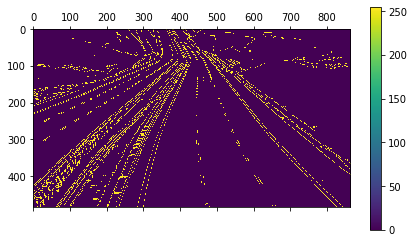

In [17]:
plt.matshow(edge_image1);
plt.colorbar()
plt.show()

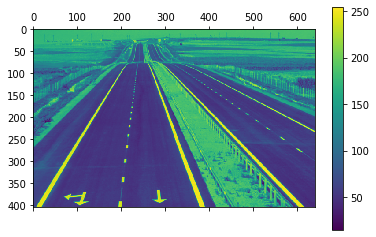

In [5]:
plt.matshow(Highway2_img);
plt.colorbar()
plt.show()

In [26]:
  
import numpy as np
import imageio
import math

def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

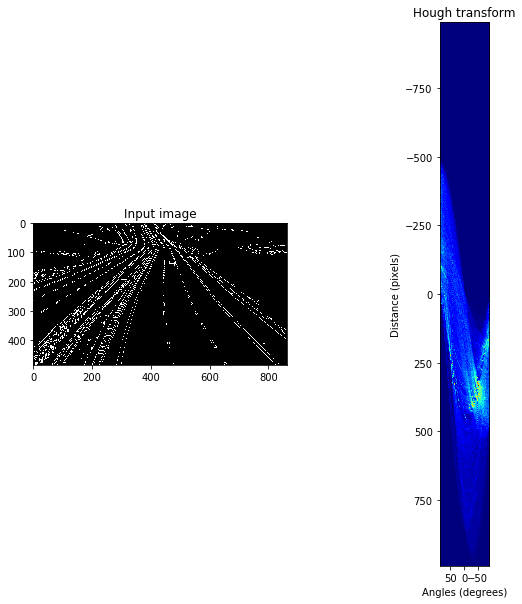

In [28]:
accumulator, thetas, rhos = hough_line(edge_image1)
show_hough_line(edge_image1, accumulator, thetas, rhos)

4461176